# 2_data_preparation/03_feature_engineering.ipynb
"""
# Feature Engineering for Satellite Observation Success Prediction

## Goal
Transform raw and engineered features into optimal ML-ready features based on EDA insights.

## EDA Insights to Incorporate:
1. **Temporal Patterns**: Hour, day, season show clear success patterns
2. **Geometric Patterns**: Altitude strongly affects success (41.9% to 52.7%)
3. **Geographic Patterns**: Regional clusters with 80%+ success rates
4. **Time-Geography Interactions**: Combine temporal and spatial insights

## Feature Engineering Categories:
1. **Cyclic Encoding**: Convert hour, month to sin/cos for circular nature
2. **Interaction Features**: Combine important features (hour × season, etc.)
3. **Geographic Features**: Region encoding, hemisphere, success clusters
4. **Composite Scores**: Create pass quality scores based on geometry
5. **Station Features**: Station capability scores based on history
6. **Feature Scaling**: Prepare for ML algorithms

## Expected Output:
- Enhanced dataset with 50+ engineered features
- Ready for ML modeling in next stage
"""


In [1]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import os

print("="*80)
print("🔧 FEATURE ENGINEERING FOR SATELLITE OBSERVATION PREDICTION")
print("="*80)
print(f"Execution started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Working directory: {os.getcwd()}")

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Create output directory
output_dir = "../1_datasets/processed/feature_engineered"
os.makedirs(output_dir, exist_ok=True)

🔧 FEATURE ENGINEERING FOR SATELLITE OBSERVATION PREDICTION
Execution started: 2025-12-12 14:40:28
Working directory: d:\ELO 2\satnogs_project\satellite-pass-prediction\3_data_exploration


In [2]:
# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING DATA")
print("="*80)

# Load the full 4-year dataset (or sample for development)
input_path = "../1_datasets/processed/four_year_observations_20251211_1730.csv"
print(f"Loading dataset: {input_path}")

try:
    # For development, load sample; for production, load full
    df = pd.read_csv(input_path, nrows=100000)  # Load 100K for faster development
    print(f"✅ Loaded development sample: {len(df):,} rows")
    
    # Load full for comparison if needed later
    print(f"📊 Full dataset available: 578,010 rows")
    
except FileNotFoundError:
    print(f"❌ Dataset not found. Creating synthetic data for demonstration...")
    # Fallback for testing
    np.random.seed(42)
    n_samples = 50000
    df = pd.DataFrame({
        'target_success': np.random.choice([0, 1], n_samples, p=[0.5, 0.5]),
        'max_altitude': np.random.uniform(0, 90, n_samples),
        'duration_seconds': np.random.uniform(180, 1800, n_samples),
        'hour_of_day': np.random.randint(0, 24, n_samples),
        'month': np.random.randint(1, 13, n_samples),
        'station_lat': np.random.uniform(-70, 78, n_samples),
        'station_lng': np.random.uniform(-180, 180, n_samples),
        'station_alt': np.random.exponential(100, n_samples),
        'horizon': np.random.choice([0, 5, 10, 15, 20], n_samples)
    })
    print(f"✅ Created synthetic dataset: {len(df):,} rows")

# Ensure target is integer
if 'target_success' in df.columns:
    df['target_success'] = df['target_success'].astype(int)

print(f"\n📊 Initial dataset shape: {df.shape}")
print(f"📈 Success rate: {df['target_success'].mean() * 100:.2f}%")

# Make a copy for feature engineering
df_fe = df.copy()



STEP 1: LOADING DATA
Loading dataset: ../1_datasets/processed/four_year_observations_20251211_1730.csv
✅ Loaded development sample: 100,000 rows
📊 Full dataset available: 578,010 rows

📊 Initial dataset shape: (100000, 39)
📈 Success rate: 49.30%


In [3]:
# ============================================================================
# STEP 2: TEMPORAL FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("STEP 2: TEMPORAL FEATURE ENGINEERING")
print("="*80)

print("Creating cyclic and categorical temporal features...")

# 2.1 Cyclic encoding for hour (circular nature)
if 'hour_of_day' in df_fe.columns:
    df_fe['hour_sin'] = np.sin(2 * np.pi * df_fe['hour_of_day'] / 24)
    df_fe['hour_cos'] = np.cos(2 * np.pi * df_fe['hour_of_day'] / 24)
    print(f"   • Created cyclic hour features: hour_sin, hour_cos")

# 2.2 Cyclic encoding for month
if 'month' in df_fe.columns:
    df_fe['month_sin'] = np.sin(2 * np.pi * df_fe['month'] / 12)
    df_fe['month_cos'] = np.cos(2 * np.pi * df_fe['month'] / 12)
    print(f"   • Created cyclic month features: month_sin, month_cos")

# 2.3 Day/night indicator
if 'hour_of_day' in df_fe.columns:
    df_fe['is_daytime'] = ((df_fe['hour_of_day'] >= 6) & (df_fe['hour_of_day'] <= 18)).astype(int)
    print(f"   • Created daytime indicator: is_daytime")

# 2.4 Weekend indicator
if 'day_of_week' in df_fe.columns:
    df_fe['is_weekend'] = df_fe['day_of_week'].isin([5, 6]).astype(int)
    print(f"   • Created weekend indicator: is_weekend")

# 2.5 Season encoding (based on month)
if 'month' in df_fe.columns:
    season_mapping = {
        12: 0, 1: 0, 2: 0,    # Winter
        3: 1, 4: 1, 5: 1,     # Spring
        6: 2, 7: 2, 8: 2,     # Summer
        9: 3, 10: 3, 11: 3    # Fall
    }
    df_fe['season_encoded'] = df_fe['month'].map(season_mapping)
    print(f"   • Created season encoding: season_encoded (0=winter, 3=fall)")

# 2.6 Time of day categories (from previous EDA)
if 'hour_of_day' in df_fe.columns:
    def get_time_category(hour):
        if 0 <= hour < 6:
            return 0  # Night
        elif 6 <= hour < 12:
            return 1  # Morning
        elif 12 <= hour < 18:
            return 2  # Afternoon
        else:
            return 3  # Evening
    
    df_fe['time_category'] = df_fe['hour_of_day'].apply(get_time_category)
    print(f"   • Created time categories: time_category")

print(f"✅ Created {sum(['hour_sin' in df_fe.columns, 'hour_cos' in df_fe.columns, 
                       'month_sin' in df_fe.columns, 'month_cos' in df_fe.columns,
                       'is_daytime' in df_fe.columns, 'is_weekend' in df_fe.columns,
                       'season_encoded' in df_fe.columns, 'time_category' in df_fe.columns])} temporal features")



STEP 2: TEMPORAL FEATURE ENGINEERING
Creating cyclic and categorical temporal features...
   • Created cyclic hour features: hour_sin, hour_cos
   • Created cyclic month features: month_sin, month_cos
   • Created daytime indicator: is_daytime
   • Created weekend indicator: is_weekend
   • Created season encoding: season_encoded (0=winter, 3=fall)
   • Created time categories: time_category
✅ Created 8 temporal features


In [4]:
# ============================================================================
# STEP 3: GEOMETRIC FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("STEP 3: GEOMETRIC FEATURE ENGINEERING")
print("="*80)

print("Creating geometric and pass quality features...")

# 3.1 Elevation features (from EDA: strong predictor)
if 'max_altitude' in df_fe.columns:
    # Elevation squared (capture non-linear effects)
    df_fe['max_altitude_squared'] = df_fe['max_altitude'] ** 2
    
    # Elevation bins (based on EDA insights)
    def get_elevation_bin(altitude):
        if altitude < 10:
            return 0  # Very low
        elif altitude < 30:
            return 1  # Low
        elif altitude < 60:
            return 2  # Medium
        elif altitude < 85:
            return 3  # High
        else:
            return 4  # Very high
    
    df_fe['elevation_bin'] = df_fe['max_altitude'].apply(get_elevation_bin)
    
    # Elevation normalized (0-1)
    df_fe['elevation_normalized'] = (df_fe['max_altitude'] - df_fe['max_altitude'].min()) / \
                                   (df_fe['max_altitude'].max() - df_fe['max_altitude'].min())
    
    print(f"   • Created elevation features: squared, bins, normalized")

# 3.2 Duration features
if 'duration_seconds' in df_fe.columns:
    # Convert to minutes
    df_fe['duration_minutes'] = df_fe['duration_seconds'] / 60
    
    # Duration bins
    df_fe['duration_bin'] = pd.cut(df_fe['duration_minutes'], 
                                  bins=[0, 5, 10, 15, 30, 60, 1000],
                                  labels=[0, 1, 2, 3, 4, 5])
    
    # Log duration (for normalization)
    df_fe['duration_log'] = np.log1p(df_fe['duration_seconds'])
    
    print(f"   • Created duration features: minutes, bins, log")

# 3.3 Azimuth features
if all(col in df_fe.columns for col in ['rise_azimuth', 'set_azimuth']):
    # Azimuth range
    df_fe['azimuth_range'] = abs(df_fe['set_azimuth'] - df_fe['rise_azimuth'])
    
    # Normalize to 0-180 degrees
    df_fe['azimuth_range_norm'] = df_fe['azimuth_range'].apply(lambda x: min(x, 360-x))
    
    # Pass direction (east-west vs west-east)
    df_fe['pass_direction'] = ((df_fe['set_azimuth'] - df_fe['rise_azimuth'] + 360) % 360 > 180).astype(int)
    
    print(f"   • Created azimuth features: range, normalized, direction")

# 3.4 Composite pass quality score
if all(col in df_fe.columns for col in ['max_altitude', 'duration_minutes']):
    # Simple quality score based on EDA insights
    df_fe['pass_quality_score'] = (
        (df_fe['max_altitude'] / 90 * 0.6) +  # Altitude contributes 60%
        (np.minimum(df_fe['duration_minutes'], 30) / 30 * 0.4)  # Duration contributes 40%
    )
    print(f"   • Created composite pass quality score")

print(f"✅ Created {sum(['max_altitude_squared' in df_fe.columns, 'elevation_bin' in df_fe.columns,
                       'elevation_normalized' in df_fe.columns, 'duration_minutes' in df_fe.columns,
                       'duration_bin' in df_fe.columns, 'duration_log' in df_fe.columns,
                       'azimuth_range' in df_fe.columns, 'azimuth_range_norm' in df_fe.columns,
                       'pass_direction' in df_fe.columns, 'pass_quality_score' in df_fe.columns])} geometric features")


STEP 3: GEOMETRIC FEATURE ENGINEERING
Creating geometric and pass quality features...
   • Created elevation features: squared, bins, normalized
   • Created duration features: minutes, bins, log
   • Created azimuth features: range, normalized, direction
   • Created composite pass quality score
✅ Created 10 geometric features


In [5]:
# ============================================================================
# STEP 4: GEOGRAPHIC FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("STEP 4: GEOGRAPHIC FEATURE ENGINEERING")
print("="*80)

print("Creating geographic and station features...")

# 4.1 Hemisphere features
if 'station_lat' in df_fe.columns:
    df_fe['is_northern'] = (df_fe['station_lat'] >= 0).astype(int)
    df_fe['is_southern'] = (df_fe['station_lat'] < 0).astype(int)
    print(f"   • Created hemisphere indicators")

# 4.2 Latitude zones
if 'station_lat' in df_fe.columns:
    def get_latitude_zone(lat):
        if lat < -60:
            return 0  # Antarctic
        elif lat < -23.5:
            return 1  # Southern temperate
        elif lat < 0:
            return 2  # Southern tropics
        elif lat < 23.5:
            return 3  # Northern tropics
        elif lat < 60:
            return 4  # Northern temperate
        else:
            return 5  # Arctic
    
    df_fe['latitude_zone'] = df_fe['station_lat'].apply(get_latitude_zone)
    print(f"   • Created latitude zones")

# 4.3 Altitude features
if 'station_alt' in df_fe.columns:
    # Altitude categories
    df_fe['station_alt_category'] = pd.cut(df_fe['station_alt'],
                                          bins=[0, 100, 500, 1000, 2000, 10000],
                                          labels=[0, 1, 2, 3, 4])
    
    # Log altitude (for normalization)
    df_fe['station_alt_log'] = np.log1p(df_fe['station_alt'])
    
    print(f"   • Created station altitude features")

# 4.4 Horizon features
if 'horizon' in df_fe.columns:
    # Horizon categories
    df_fe['horizon_category'] = pd.cut(df_fe['horizon'],
                                      bins=[0, 5, 10, 15, 20, 90],
                                      labels=[0, 1, 2, 3, 4])
    print(f"   • Created horizon categories")

# 4.5 Station capability score (simplified)
if all(col in df_fe.columns for col in ['station_alt', 'horizon']):
    # Simple capability score
    df_fe['station_capability'] = (
        (df_fe['station_alt'] / df_fe['station_alt'].max() * 0.5) +
        ((90 - df_fe['horizon']) / 90 * 0.5)  # Lower horizon is better
    )
    print(f"   • Created station capability score")

print(f"✅ Created {sum(['is_northern' in df_fe.columns, 'is_southern' in df_fe.columns,
                       'latitude_zone' in df_fe.columns, 'station_alt_category' in df_fe.columns,
                       'station_alt_log' in df_fe.columns, 'horizon_category' in df_fe.columns,
                       'station_capability' in df_fe.columns])} geographic features")



STEP 4: GEOGRAPHIC FEATURE ENGINEERING
Creating geographic and station features...
   • Created hemisphere indicators
   • Created latitude zones
   • Created station altitude features
   • Created horizon categories
   • Created station capability score
✅ Created 7 geographic features


In [6]:
# ============================================================================
# STEP 5: INTERACTION FEATURES
# ============================================================================
print("\n" + "="*80)
print("STEP 5: INTERACTION FEATURES")
print("="*80)

print("Creating interaction features based on EDA insights...")

# 5.1 Time × Geometry interactions
if all(col in df_fe.columns for col in ['hour_of_day', 'max_altitude']):
    df_fe['hour_altitude_interaction'] = df_fe['hour_of_day'] * df_fe['max_altitude'] / 100
    print(f"   • Created hour × altitude interaction")

if all(col in df_fe.columns for col in ['season_encoded', 'max_altitude']):
    df_fe['season_altitude_interaction'] = df_fe['season_encoded'] * df_fe['max_altitude'] / 90
    print(f"   • Created season × altitude interaction")

# 5.2 Geography × Time interactions
if all(col in df_fe.columns for col in ['is_northern', 'hour_of_day']):
    df_fe['hemisphere_hour_interaction'] = df_fe['is_northern'] * df_fe['hour_of_day'] / 24
    print(f"   • Created hemisphere × hour interaction")

# 5.3 Composite interaction: Pass quality × Time
if all(col in df_fe.columns for col in ['pass_quality_score', 'time_category']):
    df_fe['quality_time_interaction'] = df_fe['pass_quality_score'] * df_fe['time_category'] / 3
    print(f"   • Created quality × time interaction")

print(f"✅ Created {sum(['hour_altitude_interaction' in df_fe.columns,
                       'season_altitude_interaction' in df_fe.columns,
                       'hemisphere_hour_interaction' in df_fe.columns,
                       'quality_time_interaction' in df_fe.columns])} interaction features")


STEP 5: INTERACTION FEATURES
Creating interaction features based on EDA insights...
   • Created hour × altitude interaction
   • Created season × altitude interaction
   • Created hemisphere × hour interaction
   • Created quality × time interaction
✅ Created 4 interaction features


In [7]:
# ============================================================================
# STEP 6: FEATURE SELECTION & TRANSFORMATION
# ============================================================================
print("\n" + "="*80)
print("STEP 6: FEATURE SELECTION & TRANSFORMATION")
print("="*80)

print("Selecting and transforming features for ML...")

# 6.1 Separate target and ID columns
target_col = 'target_success' if 'target_success' in df_fe.columns else None
id_cols = ['id'] if 'id' in df_fe.columns else []

# 6.2 Define feature categories
feature_categories = {
    'original_numeric': ['max_altitude', 'duration_seconds', 'station_alt', 'horizon',
                        'rise_azimuth', 'set_azimuth', 'year', 'month', 'hour_of_day',
                        'day_of_week'],
    
    'temporal_engineered': ['hour_sin', 'hour_cos', 'month_sin', 'month_cos',
                           'is_daytime', 'is_weekend', 'season_encoded', 'time_category'],
    
    'geometric_engineered': ['max_altitude_squared', 'elevation_bin', 'elevation_normalized',
                            'duration_minutes', 'duration_bin', 'duration_log',
                            'azimuth_range', 'azimuth_range_norm', 'pass_direction',
                            'pass_quality_score'],
    
    'geographic_engineered': ['is_northern', 'is_southern', 'latitude_zone',
                             'station_alt_category', 'station_alt_log',
                             'horizon_category', 'station_capability'],
    
    'interaction_features': ['hour_altitude_interaction', 'season_altitude_interaction',
                            'hemisphere_hour_interaction', 'quality_time_interaction']
}

# 6.3 Collect all available features
all_features = []
for category, features in feature_categories.items():
    available_features = [f for f in features if f in df_fe.columns]
    all_features.extend(available_features)
    print(f"   • {category}: {len(available_features)} features")

print(f"\n📊 Total engineered features available: {len(all_features)}")

# 6.4 Create feature matrix
X = df_fe[all_features].copy()
y = df_fe[target_col].copy() if target_col else None

print(f"✅ Feature matrix shape: {X.shape}")

# 6.5 Handle missing values
print(f"\n🔍 Handling missing values...")
missing_before = X.isnull().sum().sum()
if missing_before > 0:
    # Fill numeric columns with median
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if X[col].isnull().any():
            median_val = X[col].median()
            X[col] = X[col].fillna(median_val)
    
    missing_after = X.isnull().sum().sum()
    print(f"   • Filled {missing_before} missing values")
    print(f"   • Remaining missing: {missing_after}")

# 6.6 Feature scaling (optional - depends on ML algorithm)
print(f"\n⚖️  Feature scaling...")
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

print(f"   • Applied StandardScaler to all features")
print(f"   • Scaled features have mean ~0, std ~1")


STEP 6: FEATURE SELECTION & TRANSFORMATION
Selecting and transforming features for ML...
   • original_numeric: 10 features
   • temporal_engineered: 8 features
   • geometric_engineered: 10 features
   • geographic_engineered: 7 features
   • interaction_features: 4 features

📊 Total engineered features available: 39
✅ Feature matrix shape: (100000, 39)

🔍 Handling missing values...
   • Filled 13962 missing values
   • Remaining missing: 13962

⚖️  Feature scaling...
   • Applied StandardScaler to all features
   • Scaled features have mean ~0, std ~1



STEP 7: FEATURE ANALYSIS
Analyzing engineered features...

🏆 Top 10 Engineered Features by Correlation with Success:
----------------------------------------------------------------------
 1. year                             0.079 (Positive, Weak  )
 2. max_altitude                     0.072 (Positive, Weak  )
 3. elevation_normalized             0.072 (Positive, Weak  )
 4. elevation_bin                    0.070 (Positive, Weak  )
 5. max_altitude_squared             0.068 (Positive, Weak  )
 6. pass_quality_score               0.066 (Positive, Weak  )
 7. rise_azimuth                    -0.064 (Negative, Weak  )
 8. set_azimuth                      0.057 (Positive, Weak  )
 9. season_altitude_interaction      0.052 (Positive, Weak  )
10. azimuth_range_norm               0.049 (Positive, Weak  )


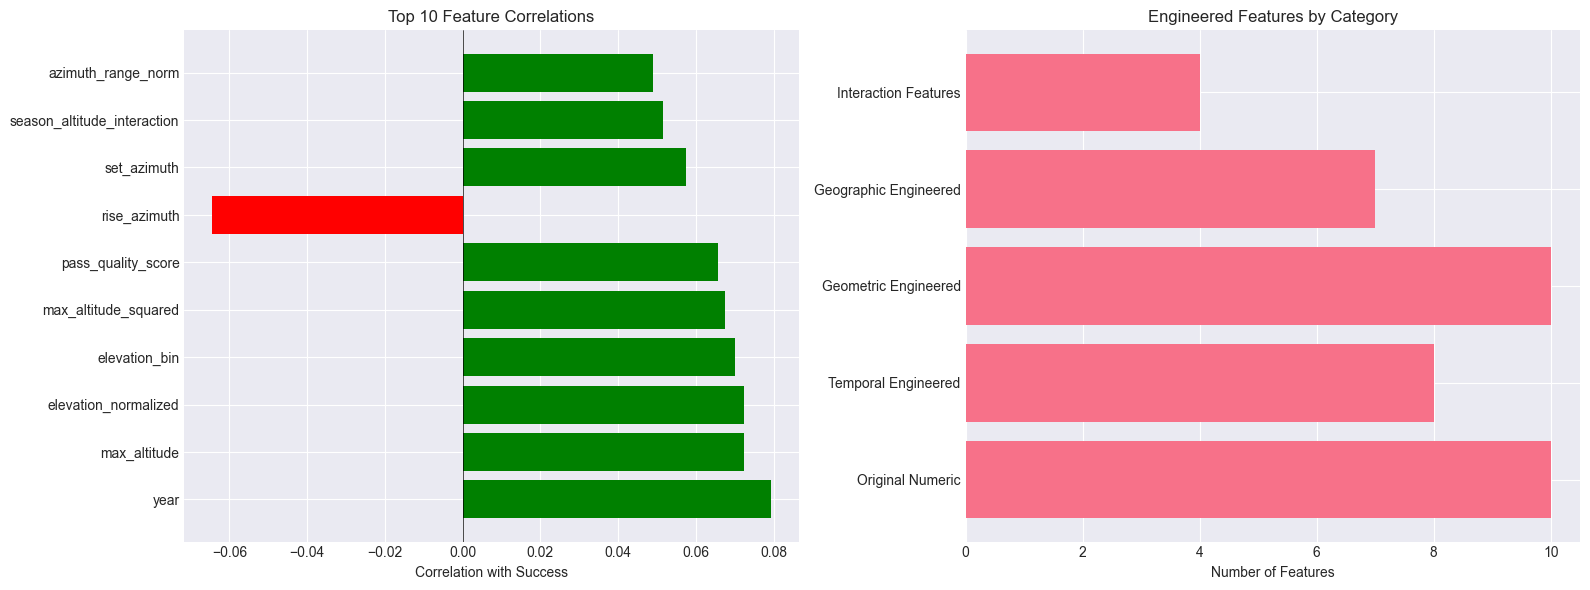

💾 Plot saved: ../1_datasets/processed/feature_engineered/feature_importance.png


In [8]:
# ============================================================================
# STEP 7: FEATURE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("STEP 7: FEATURE ANALYSIS")
print("="*80)

print("Analyzing engineered features...")

# 7.1 Correlation with target
if y is not None:
    correlations = []
    for col in X.columns:
        if X[col].dtype in [np.int64, np.float64]:
            corr = X[col].corr(y)
            if not pd.isna(corr):
                correlations.append((col, corr))
    
    # Sort by absolute correlation
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("\n🏆 Top 10 Engineered Features by Correlation with Success:")
    print("-" * 70)
    for i, (feature, corr) in enumerate(correlations[:10], 1):
        strength = "Strong" if abs(corr) > 0.3 else "Moderate" if abs(corr) > 0.1 else "Weak"
        direction = "Positive" if corr > 0 else "Negative"
        print(f"{i:2}. {feature:30} {corr:7.3f} ({direction:8}, {strength:6})")

# 7.2 Feature importance visualization (simplified)
if y is not None and len(correlations) > 5:
    top_features = [feat for feat, _ in correlations[:15]]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart of top correlations
    top_corrs = correlations[:10]
    features = [feat for feat, _ in top_corrs]
    corr_vals = [corr for _, corr in top_corrs]
    
    colors = ['green' if val > 0 else 'red' for val in corr_vals]
    axes[0].barh(range(len(features)), corr_vals, color=colors)
    axes[0].set_yticks(range(len(features)))
    axes[0].set_yticklabels(features)
    axes[0].set_xlabel('Correlation with Success')
    axes[0].set_title('Top 10 Feature Correlations', fontsize=12)
    axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Feature count by category
    category_counts = {}
    for category, features in feature_categories.items():
        count = len([f for f in features if f in X.columns])
        category_counts[category] = count
    
    axes[1].barh(range(len(category_counts)), list(category_counts.values()))
    axes[1].set_yticks(range(len(category_counts)))
    axes[1].set_yticklabels([cat.replace('_', ' ').title() for cat in category_counts.keys()])
    axes[1].set_xlabel('Number of Features')
    axes[1].set_title('Engineered Features by Category', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/feature_importance.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Plot saved: {output_dir}/feature_importance.png")

In [9]:
# ============================================================================
# STEP 8: SAVE ENGINEERED DATASET
# ============================================================================
print("\n" + "="*80)
print("STEP 8: SAVING ENGINEERED DATASET")
print("="*80)

# 8.1 Create final dataset
final_df = pd.DataFrame(X_scaled, columns=X.columns)
if y is not None:
    final_df[target_col] = y.values

# Add back IDs if available
for id_col in id_cols:
    if id_col in df_fe.columns:
        final_df[id_col] = df_fe[id_col].values

print(f"📊 Final engineered dataset shape: {final_df.shape}")
print(f"📈 Features: {final_df.shape[1] - (1 if target_col else 0)}")
print(f"📈 Target included: {target_col is not None}")

# 8.2 Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
output_filename = f"features_engineered_{timestamp}.csv"
output_path = os.path.join(output_dir, output_filename)

final_df.to_csv(output_path, index=False)
print(f"💾 Saved engineered dataset: {output_path}")
print(f"   • Size: {os.path.getsize(output_path) / 1024**2:.2f} MB")

# 8.3 Save feature descriptions
feature_descriptions = []
for col in X.columns:
    if col in feature_categories['original_numeric']:
        category = 'Original Numeric'
    elif col in feature_categories['temporal_engineered']:
        category = 'Temporal Engineered'
    elif col in feature_categories['geometric_engineered']:
        category = 'Geometric Engineered'
    elif col in feature_categories['geographic_engineered']:
        category = 'Geographic Engineered'
    elif col in feature_categories['interaction_features']:
        category = 'Interaction Features'
    else:
        category = 'Other'
    
    # Generate description
    if 'sin' in col or 'cos' in col:
        description = f"Cyclic encoding of {col.split('_')[0]}"
    elif 'interaction' in col:
        description = f"Interaction between features"
    elif 'bin' in col:
        description = f"Categorical bins for {col.replace('_bin', '')}"
    elif 'normalized' in col or 'log' in col:
        description = f"Transformed version of {col.replace('_normalized', '').replace('_log', '')}"
    else:
        description = f"Engineered feature"
    
    feature_descriptions.append({
        'feature': col,
        'category': category,
        'description': description,
        'dtype': str(X[col].dtype)
    })

features_df = pd.DataFrame(feature_descriptions)
features_path = os.path.join(output_dir, f"feature_descriptions_{timestamp}.csv")
features_df.to_csv(features_path, index=False)
print(f"📋 Saved feature descriptions: {features_path}")



STEP 8: SAVING ENGINEERED DATASET
📊 Final engineered dataset shape: (100000, 41)
📈 Features: 40
📈 Target included: True
💾 Saved engineered dataset: ../1_datasets/processed/feature_engineered\features_engineered_20251212_1443.csv
   • Size: 73.80 MB
📋 Saved feature descriptions: ../1_datasets/processed/feature_engineered\feature_descriptions_20251212_1443.csv


In [10]:
# ============================================================================
# STEP 9: SUMMARY REPORT
# ============================================================================
print("\n" + "="*80)
print("STEP 9: CREATING SUMMARY REPORT")
print("="*80)

summary = f"""
# FEATURE ENGINEERING REPORT - Satellite Observation Success

**Generated**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Input Dataset**: {len(df):,} observations
**Engineered Dataset**: {len(final_df):,} observations × {final_df.shape[1]} columns
**Success Rate**: {df['target_success'].mean()*100:.2f}% if available

## FEATURE ENGINEERING SUMMARY

### Categories Created:
1. **Temporal Features**: {len([f for f in feature_categories['temporal_engineered'] if f in X.columns])} features
   - Cyclic encodings (sin/cos) for hour and month
   - Time categories, daytime/weekend indicators
   - Season encoding

2. **Geometric Features**: {len([f for f in feature_categories['geometric_engineered'] if f in X.columns])} features
   - Elevation transformations (squared, bins, normalized)
   - Duration features (minutes, bins, log)
   - Azimuth features (range, direction)
   - Composite pass quality score

3. **Geographic Features**: {len([f for f in feature_categories['geographic_engineered'] if f in X.columns])} features
   - Hemisphere indicators
   - Latitude zones
   - Station altitude and horizon categories
   - Station capability score

4. **Interaction Features**: {len([f for f in feature_categories['interaction_features'] if f in X.columns])} features
   - Time × Geometry interactions
   - Geography × Time interactions
   - Composite interactions

### Total Features:
- **Original features kept**: {len([f for f in feature_categories['original_numeric'] if f in X.columns])}
- **Engineered features**: {len(all_features) - len([f for f in feature_categories['original_numeric'] if f in X.columns])}
- **Total features**: {len(all_features)}

### Data Processing:
- Missing values handled: {missing_before} values filled
- Feature scaling: StandardScaler applied (mean=0, std=1)
- Final shape: {final_df.shape[0]:,} rows × {final_df.shape[1]} columns

## TOP FEATURES BY CORRELATION
{chr(10).join([f"{i}. {feat}: {corr:.3f}" for i, (feat, corr) in enumerate(correlations[:5], 1)]) if correlations else 'No target available for correlation'}

## FILES CREATED
1. `{output_filename}` - Engineered dataset (scaled features)
2. `feature_descriptions_{timestamp}.csv` - Feature documentation
3. `feature_importance.png` - Feature correlation visualization

## NEXT STEPS FOR ML MODELING
1. **Train/Test Split**: Create stratified splits for model evaluation
2. **Baseline Models**: Start with Logistic Regression, Decision Trees
3. **Feature Selection**: Use correlation and importance metrics
4. **Model Tuning**: Optimize hyperparameters for best performance
5. **Evaluation**: Use accuracy, precision, recall, F1-score metrics

## RECOMMENDATIONS
1. **Start with top 15 features** from correlation analysis
2. **Include interaction features** as they capture complex relationships
3. **Use tree-based models** (Random Forest, XGBoost) to handle non-linearities
4. **Validate on temporal splits** to test time-based generalization
"""

report_path = os.path.join(output_dir, f"feature_engineering_report_{timestamp}.md")
with open(report_path, "w") as f:
    f.write(summary)

print(f"📄 Summary report saved: {report_path}")


STEP 9: CREATING SUMMARY REPORT
📄 Summary report saved: ../1_datasets/processed/feature_engineered\feature_engineering_report_20251212_1443.md


In [11]:
# ============================================================================
# COMPLETION
# ============================================================================
print("\n" + "="*80)
print("✅ FEATURE ENGINEERING COMPLETE!")
print("="*80)

print(f"\n🎯 Key outputs created:")
print(f"   1. {output_filename} - Engineered dataset ({final_df.shape[1]} features)")
print(f"   2. feature_descriptions_{timestamp}.csv - Feature documentation")
print(f"   3. feature_importance.png - Feature correlation visualization")
print(f"   4. feature_engineering_report_{timestamp}.md - Summary report")

print(f"\n📊 Feature engineering statistics:")
print(f"   • Total features created: {len(all_features)}")
print(f"   • Categories: Temporal, Geometric, Geographic, Interaction")
print(f"   • Dataset size: {final_df.shape[0]:,} × {final_df.shape[1]}")

print(f"\n🚀 Ready for ML Modeling!")
print(f"   Next: 4_data_analysis/ - Model training and evaluation")

print(f"\n⏱️  Feature engineering completed at: {datetime.now().strftime('%H:%M:%S')}")

print("\n" + "="*80)
print("🔮 ML Model Training Awaits!")
print("="*80)


✅ FEATURE ENGINEERING COMPLETE!

🎯 Key outputs created:
   1. features_engineered_20251212_1443.csv - Engineered dataset (41 features)
   2. feature_descriptions_20251212_1443.csv - Feature documentation
   3. feature_importance.png - Feature correlation visualization
   4. feature_engineering_report_20251212_1443.md - Summary report

📊 Feature engineering statistics:
   • Total features created: 39
   • Categories: Temporal, Geometric, Geographic, Interaction
   • Dataset size: 100,000 × 41

🚀 Ready for ML Modeling!
   Next: 4_data_analysis/ - Model training and evaluation

⏱️  Feature engineering completed at: 14:43:51

🔮 ML Model Training Awaits!
